# DATA ANALYSIS REPORT
The aim of this study is to predict the gas usage with time and characteristics of weather e.g., temperature. In the prediction model, we would care more about which feature has more predictive value on gas usage.
In order to do that, a random forest was included for the modelling. Random forest is an ensemble method which can capture both linear and non-linear relationships between predictors and response variables. 

### Preliminaries 
Import the p1g dataset with:

`python3 p1g.py -d sqlite:///myhome.db ./data/P1g`

Import the openweathermap dataset with:

`python3 openweathermap.py -d sqlite:///myhome2.db 2022-01-01 2024-04-01`

### Loading the datasets:

In [2]:
import sqlalchemy as sa
import pandas as pd
import seaborn as sns

# get the data from table p1g
engine = sa.create_engine("sqlite:///myhome.db")
sql = sa.text("SELECT * FROM p1g")
p1g_df = pd.read_sql(sql, con=engine)
p1g_df.dropna(axis=0, inplace=True)
print(p1g_df.head())

# get the data from table openweather
engine = sa.create_engine("sqlite:///myhome2.db")
sql = sa.text("SELECT * FROM openweathermap")
openwheatermap_df = pd.read_sql(sql, con=engine)
openwheatermap_df.dropna(axis=0, inplace=True)
print(openwheatermap_df.head())
print(openwheatermap_df.columns)

# merge the two table
openwheatermap_gas = p1g_df.merge(openwheatermap_df, how="inner", on = "unixtime")
print(openwheatermap_gas.columns)



openwheatermap_gas['month'] = pd.to_datetime(openwheatermap_gas['time']).dt.month
openwheatermap_gas['year'] = pd.to_datetime(openwheatermap_gas['time']).dt.year
openwheatermap_gas.head()

               time  Total gas used    unixtime
0  2023-11-01 00:00        4956.700  1698796800
1  2023-11-01 00:15        4956.712  1698797700
2  2023-11-01 00:30        4956.725  1698798600
3  2023-11-01 00:45        4956.725  1698799500
4  2023-11-01 01:00        4956.725  1698800400
                         date  temperature_2m_°C  relativehumidity_2m_%  \
0  2022-01-01 00:00:00.000000               10.2              95.740547   
1  2022-01-01 01:00:00.000000               10.2              95.419624   
2  2022-01-01 02:00:00.000000               10.1              94.458282   
3  2022-01-01 03:00:00.000000               10.0              94.454018   
4  2022-01-01 04:00:00.000000               10.1              94.776604   

   rain_mm  snowfall_cm  windspeed_10m_km/h  winddirection_10m_°  \
0      0.0          0.0           21.028437           231.952911   
1      0.0          0.0           20.466246           230.710617   
2      0.0          0.0           22.322903           232

,time,Total gas used,unixtime,date,temperature_2m_°C,relativehumidity_2m_%,rain_mm,snowfall_cm,windspeed_10m_km/h,winddirection_10m_°,soil_temperature_0_to_7cm_°C,month,year
0,2023-11-01 00:00,4956.700,1698796800,2023-11-01 00:00:00.000000,10.90,91.686096,0.0,0.0,19.164717,208.009079,10.25,11,2023
1,2023-11-01 01:00,4956.725,1698800400,2023-11-01 01:00:00.000000,10.75,92.294479,0.0,0.0,16.279802,198.034378,10.45,11,2023
2,2023-11-01 02:00,4956.725,1698804000,2023-11-01 02:00:00.000000,10.45,94.156639,0.0,0.0,17.518356,189.462250,10.30,11,2023
3,2023-11-01 03:00,4956.725,1698807600,2023-11-01 03:00:00.000000,10.05,94.456154,0.0,0.0,14.404499,181.432068,10.10,11,2023
4,2023-11-01 04:00,4956.750,1698811200,2023-11-01 04:00:00.000000,10.40,94.154381,0.0,0.0,15.546833,174.685547,10.10,11,2023


### Variable Correlation by Month
Lets look at the relationship between the gas consumption and weather variables. The different colors in each graph represent each month. While all variables in the table with the combined datasets will be compared, we will focus on the relationship between the openweathermap variables and the total gas used.  

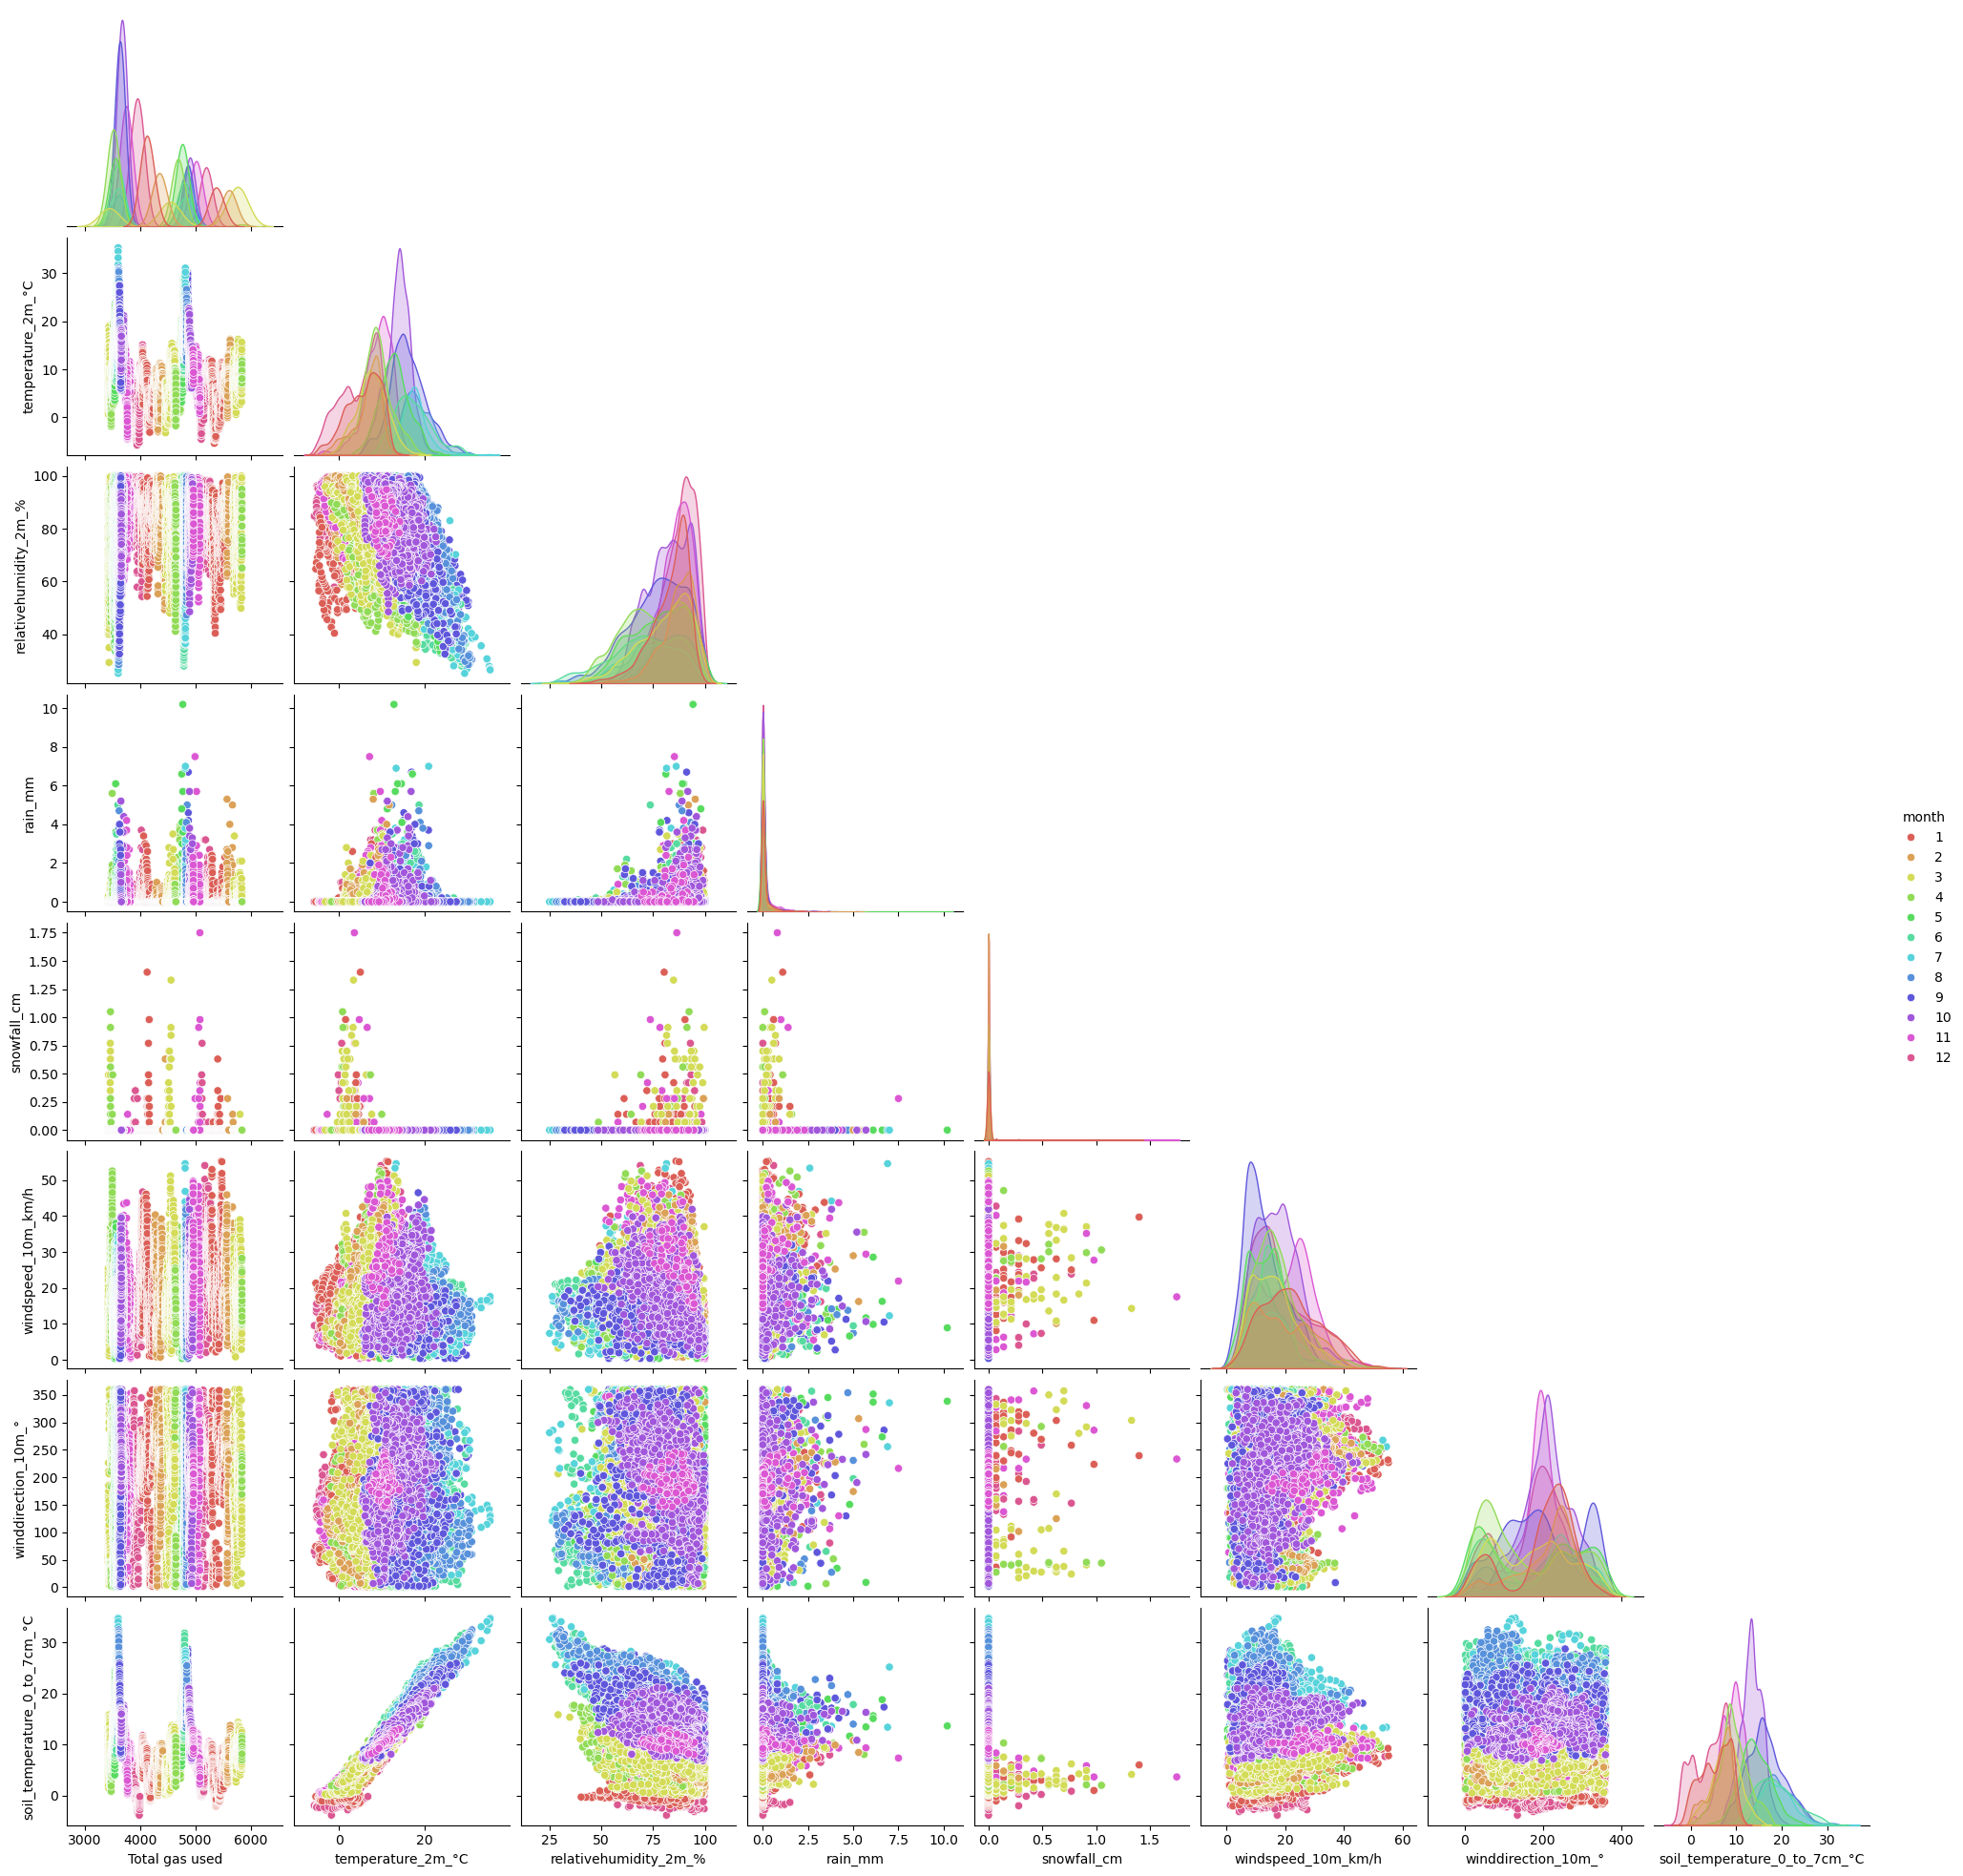

In [3]:
sns.pairplot(openwheatermap_gas.drop(columns=["time", "date", "unixtime", "year"]), hue="month", corner=True, palette=sns.color_palette("hls", 12))

Based on these plots, there is not much correlation between the total gas used and the openweathermap variables. The difference in gas consumption seems to vary the most between months; the colors for each month tend to remain in same range of gas consumption for each openweatherdata variable. 

### Variable Correlation by Year
Because each month has a strong relationship with the total gas used, lets examine the dataset by year to see if there is a similar relationship. 

c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


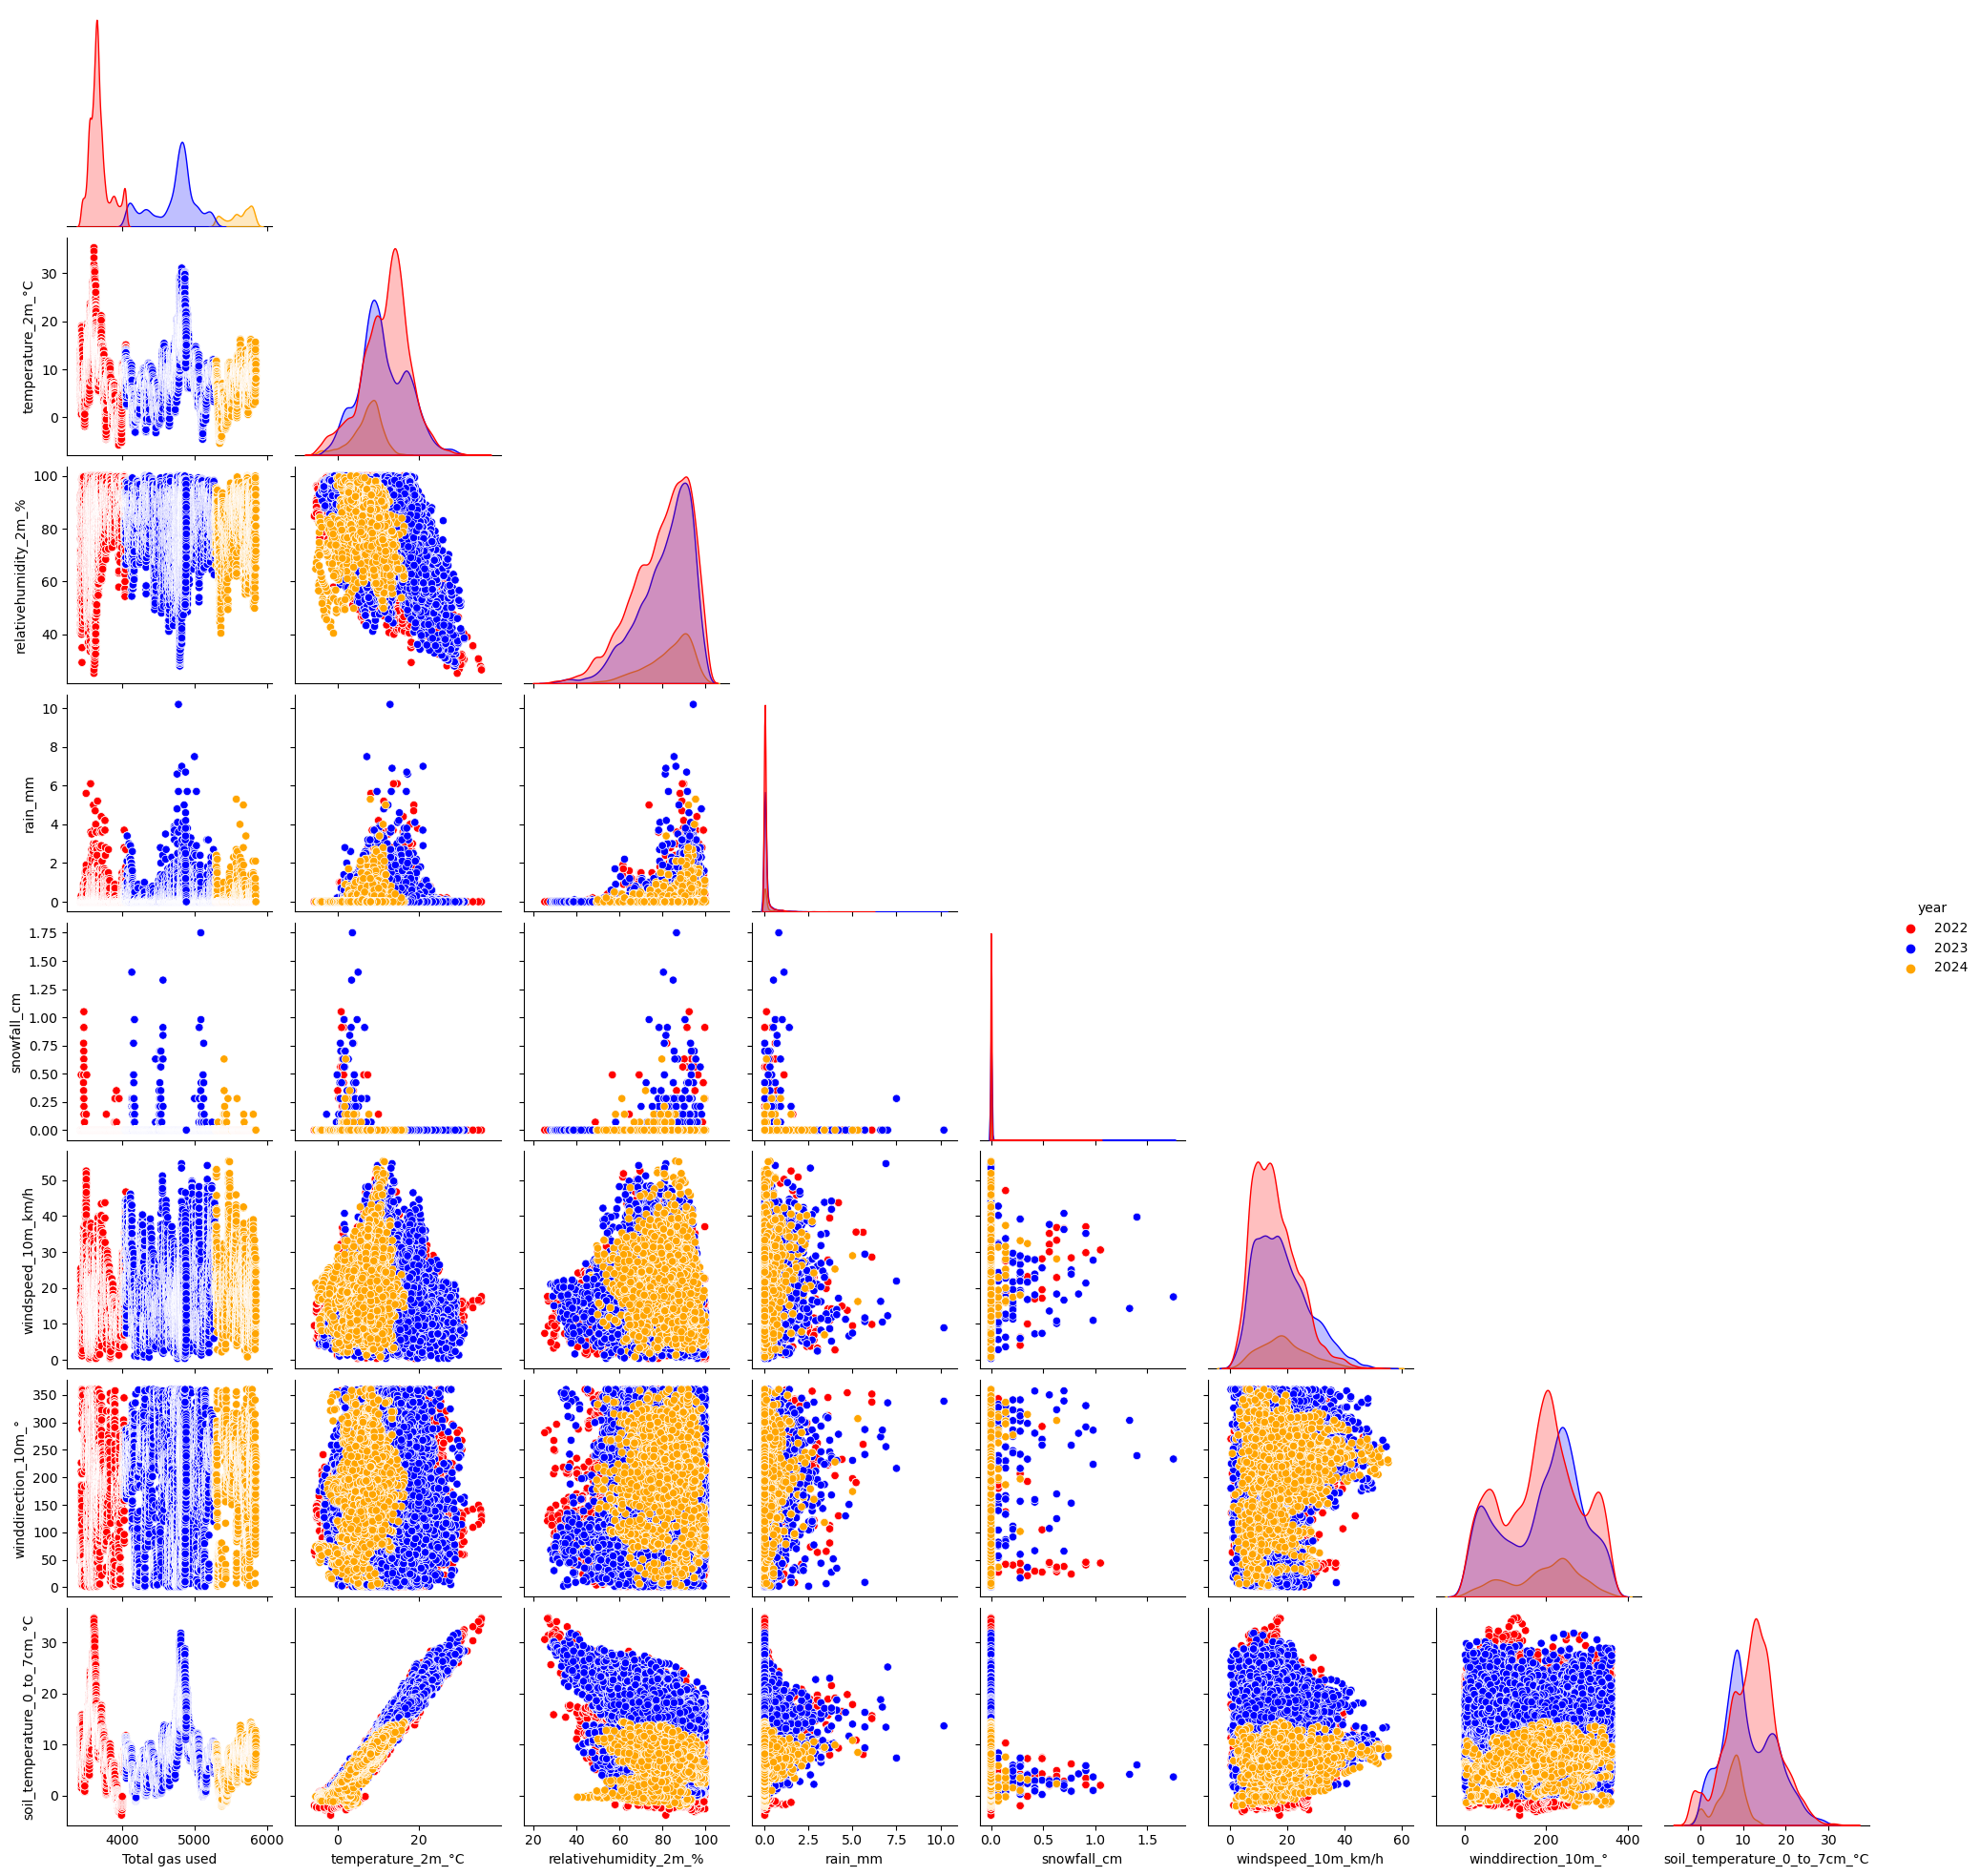

In [3]:
palette =  sns.color_palette("hls", 8)
sns.pairplot(openwheatermap_gas.drop(columns=["time", "date", "unixtime", "month"]), hue="year", corner=True, palette={2022: "red", 2023:"blue", 2024:"orange"})

Like the monthly plots, these yearly plots confirm that there is no strong relationship between the openweatherdata variables and the total gas used. However, these plots clearly show the relationship between gas consumption and years, with 2022 having the lowest gas usage levels, and 2024 having the highest. 

### Random Forest Parameter and Feature Selection
This model will help extract the most predictive variables for determining gas usage. The optimal parameters for the random forest model can be found by tuning a model with all predictors using a parameters grid. The runtime for parameter selection took 

In [10]:
from sklearn.model_selection import train_test_split
data = openwheatermap_gas.drop(columns=["time", "date", "unixtime"])
X = data.drop(columns=["Total gas used"])
y = data["Total gas used"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 200, 300],
              'min_impurity_decrease': [8, 10, 12],
              'max_features': [3, 4, 5, 6, 7],
              'max_depth': [50, 60, 70, 80, 90, 100]
              }

rf_model = RandomForestRegressor(n_estimators = 50, random_state= 40)
clf = GridSearchCV(rf_model, param_grid=parameters)



In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

After finding the best features for the random forest model, lets create a new model with these optimal parameters and use it to predict total gas usage. We can determine how well the model predicts these values by plotting the predicted values with the actual gas usage values. If the model predicts these values well, the graph will show a positive, linear relationship. 

<Axes: ylabel='Total gas used'>

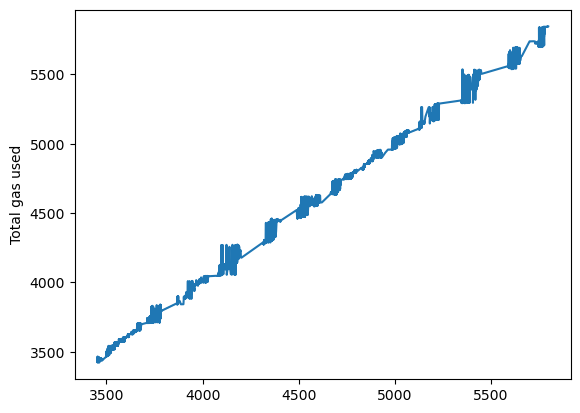

In [14]:
rf_model = RandomForestRegressor(max_depth=80, max_features=5, min_impurity_decrease=8, n_estimators=200, random_state=40)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
sns.lineplot(x=predictions, y = y_test)

Based on the random forest plot, we can conclude that this model does a decent job at predicting the actual gas usage values. The lineplot generally follows a positive linear relationship, and it is a good thing that the line is not completely straight, or else our model would be overfitting the dataset and would most likely not perform well when compared to data from a different household. 

In [ ]:
importances = rf_model.feature_importances_
columns = X.columns
i = 0

while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(importances[i] * 100, 2)}%")
    i = i + 1

The importance of feature temperature_2m_°C is 0.71%
The importance of feature relativehumidity_2m_% is 0.14%
The importance of feature rain_mm is 0.02%
The importance of feature snowfall_cm is 0.0%
The importance of feature windspeed_10m_km/h is 0.3%
The importance of feature winddirection_10m_° is 0.53%
The importance of feature soil_temperature_0_to_7cm_°C is 1.61%
The importance of feature month is 10.96%
The importance of feature year is 85.73%


According to the output we can see that variable 'year' has the most predictive value for gas usage. Furthermore, all the openweathermap variables have very small importance percentages, which further confirms the weak relationship they have with gas consumption levels. Since the month and year are the most predictive variables, we assume that is due to the underlying gas price in those years, along with shifts in employment environments. For this particular household, if these homeowners comute to work by car, the increase in petrol prices over the years would be less motivating to drive to work, and after the pandemic, it is much easier to work from home. Staying at home for work would help avoid this surge in gas prices, but at the same time, gas usage in the home would increase.  